In [34]:
from dataclasses import dataclass
from datetime import datetime
from typing import List, Optional
import talib.abstract as ta
import pandas as pd


""" 
Trading DataFrame Columns: date, open, high, low, close, volume
"""


@dataclass
class TradingStrategy:
    """Basic trading strategy"""
    timeframe: str = "5m"

    def populate_indicators(self, dataframe: pd.DataFrame) -> pd.DataFrame:
        dataframe["ma_7"] = ta.SMA(dataframe["close"], timeperiod=7)
        dataframe["ma_21"] = ta.SMA(dataframe["close"], timeperiod=21)
        macd = ta.MACD(dataframe["close"])
        dataframe["macd"] = macd[0]
        dataframe["macdsignal"] = macd[1]
        return dataframe

    def populate_enter_long(self, dataframe: pd.DataFrame) -> pd.DataFrame:
        dataframe.loc[dataframe["ma_7"] > dataframe["ma_21"], "enter_long"] = 1
        return dataframe
        
    def populate_exit_long(self, dataframe: pd.DataFrame) -> pd.DataFrame:
        dataframe.loc[dataframe["ma_7"] < dataframe["ma_21"], "exit_long"] = 1
        return dataframe
        
    def populate_enter_short(self, dataframe: pd.DataFrame) -> pd.DataFrame:
        dataframe.loc[dataframe["macd"] < dataframe["macdsignal"], "enter_short"] = 1
        return dataframe
        
    def populate_exit_short(self, dataframe: pd.DataFrame) -> pd.DataFrame:
        dataframe.loc[dataframe["macd"] > dataframe["macdsignal"], "exit_short"] = 1
        return dataframe


@dataclass
class Position:
    """Generic trading position"""
    open_date: datetime
    open_rate: float
    direction: int  # 0 for short, 1 for long
    close_date: datetime = None  # type: ignore
    close_rate: float = None  # type: ignore
    close_reason: str = None  # type: ignore
   
    
@dataclass
class BacktestConfiguration:
    """Basic backtest config"""
    starting_balance: float = 1000
    stake_amount: float = 20
    max_open_trades: int = 5
    stoploss: float = 0.05


class Backtesting:
    """Class to backtest a trading strategy"""

    def __init__(self, strategy: TradingStrategy, data: pd.DataFrame, config: BacktestConfiguration):
        self.strategy: TradingStrategy = strategy
        self.data: pd.DataFrame = data
        self.config: BacktestConfiguration = config
        self.long_position: Optional[Position] = None
        self.short_position: Optional[Position] = None
        self.closed_positions: List[Position] = []
    
    def start_backtesting(self) -> pd.DataFrame:
        self._populate_signals()
        self._populate_positions()
        return self._calculate_profits()
    
    def _populate_signals(self):
        """Populate data in a strategy"""
        self.data["enter_long"] = 0
        self.data["exit_long"] = 0
        self.data["enter_short"] = 0
        self.data["exit_short"] = 0
        self.data = self.strategy.populate_indicators(self.data)
        self.data = self.strategy.populate_enter_long(self.data)
        self.data = self.strategy.populate_exit_long(self.data)
        self.data = self.strategy.populate_enter_short(self.data)
        self.data = self.strategy.populate_exit_short(self.data)
        
    def _enter(self, direction: int, open_date: datetime, open_rate: float):
        """Enter a position"""
        if direction == 0:
            self.short_position = Position(open_date, open_rate, direction)
        elif direction == 1:
            self.long_position = Position(open_date, open_rate, direction)
            
    def _exit(self, direction: int, close_date: datetime, close_rate: float, close_reason: str):
        """Exit a position"""
        if direction == 0:
            self.short_position.close_date = close_date
            self.short_position.close_rate = close_rate
            self.short_position.close_reason = close_reason
            self.closed_positions.append(self.short_position) # type: ignore
            self.short_position = None
        elif direction == 1:
            self.long_position.close_date = close_date
            self.long_position.close_rate = close_rate
            self.long_position.close_reason = close_reason
            self.closed_positions.append(self.long_position) # type: ignore
            self.long_position = None
            
    def _check_exit_long(self, should_exit: bool, date: datetime, open: float, high: float, low: float, close: float):
        """Close a Long position if exists and condition meets"""
        if low < self.long_position.open_rate * (1 - self.config.stoploss):
            return self._exit(1, date, low, "stoploss")
        if should_exit:
            return self._exit(1, date, close, "signal")
            
    def _check_exit_short(self, should_exit: bool, date: datetime, open: float, high: float, low: float, close: float):
        """Close a Short position if exists and condition meets"""
        if high > self.short_position.open_rate * (1 + self.config.stoploss):
            return self._exit(0, date, high, "stoploss")
        if should_exit:
            return self._exit(0, date, close, "signal")
            
    def _populate_positions(self):
        """Convert DataFrame to list then loop through it to populate positions"""
        IDX_DATE = 0
        IDX_OPEN = 1
        IDX_HIGH = 2
        IDX_LOW = 3
        IDX_CLOSE = 4
        IDX_VOLUME = 5
        IDX_ENTER_LONG = 6
        IDX_EXIT_LONG = 7
        IDX_ENTER_SHORT = 8
        IDX_EXIT_SHORT = 9
        
        data = self._filter_columns().values.tolist()
        
        for i in range(len(data)):
            if self.long_position is not None:
                self._check_exit_long(
                    data[i][IDX_EXIT_LONG] == 1, 
                    data[i][IDX_DATE],
                    data[i][IDX_OPEN],
                    data[i][IDX_HIGH],
                    data[i][IDX_LOW],
                    data[i][IDX_CLOSE],
                )
            if self.short_position is not None:
                self._check_exit_short(
                    data[i][IDX_EXIT_SHORT] == 1, 
                    data[i][IDX_DATE],
                    data[i][IDX_OPEN],
                    data[i][IDX_HIGH],
                    data[i][IDX_LOW],
                    data[i][IDX_CLOSE],
                )
            
            if data[i][IDX_ENTER_LONG] == 1 and self.long_position is None:
                self._enter(1, data[i][IDX_DATE], data[i][IDX_CLOSE])
            if data[i][IDX_ENTER_SHORT] == 1 and self.short_position is None:
                self._enter(0, data[i][IDX_DATE], data[i][IDX_CLOSE])
                
    def _get_positions_dataframe(self) -> pd.DataFrame:
        """Convert closed positions into pandas DataFrame"""
        if len(self.closed_positions) == 0:
            return pd.DataFrame()
        return pd.DataFrame([[
            position.open_date,
            position.open_rate,
            position.close_date,
            position.close_rate,
            position.direction
        ] for position in self.closed_positions], columns=[
            "open_date",
            "open_rate",
            "close_date",
            "close_rate",
            "direction"
        ])
    
    def _calculate_profits(self) -> pd.DataFrame:
        """Calculate profits of our positions and other things"""
        df_positions = self._get_positions_dataframe()
        df_positions.loc[df_positions["direction"] == 0, "profit_ratio"] = (df_positions["open_rate"] - df_positions["close_rate"]) / df_positions["open_rate"]
        df_positions.loc[df_positions["direction"] == 1, "profit_ratio"] = (df_positions["close_rate"] - df_positions["open_rate"]) / df_positions["open_rate"]
        df_positions["profit_abs"] = df_positions["profit_ratio"] * self.config.stake_amount
        df_positions["profit_abs_cum"] = df_positions["profit_abs"].cumsum()
        return df_positions
        
    def _filter_columns(self) -> pd.DataFrame:
        """Filter columns from self.data"""
        df_data = self.data.copy()
        df_data = df_data[["date", "open", "high", "low", "close", "volume", "enter_long", "exit_long", "enter_short", "exit_short"]]
        return df_data

In [8]:
import os
import logging
import nest_asyncio
import sys
import gc

from pathlib import Path

# Resolve CWD
gc.collect()
nest_asyncio.apply()

while "freqtrade" not in os.listdir():
    os.chdir("..")
    if "freqtrade" in os.listdir():
        nest_asyncio.apply()
        logger = logging.getLogger("freqtrade.nbtools")
        handler = logging.StreamHandler(stream=sys.stdout)
        handler.setFormatter(logging.Formatter("%(name)s - %(message)s"))
        logger.addHandler(handler)
        logger.setLevel(logging.DEBUG)
        
PATH_MOUNT = Path.cwd().parent / "mount"
PATH_DATA = PATH_MOUNT / "data"

In [22]:
from freqtrade.ml.loader import load_df

df_load = load_df(PATH_DATA / "binance"/ "BTC_USDT-12h.json", "12h")

In [35]:
config = BacktestConfiguration()
df_data = df_load.copy()
backtester = Backtesting(TradingStrategy(), df_data, config)
result = backtester.start_backtesting()
result

,open_date,open_rate,close_date,close_rate,direction,profit_ratio,profit_abs,profit_abs_cum
0,2017-08-27 00:00:00+00:00,4323.37,2017-09-04 00:00:00+00:00,4052.00,1,-0.062768,-1.255363,-1.255363
1,2017-09-04 00:00:00+00:00,4153.00,2017-09-04 12:00:00+00:00,4100.11,1,-0.012735,-0.254707,-1.510071
2,2017-09-03 00:00:00+00:00,4486.00,2017-09-07 12:00:00+00:00,4788.59,0,-0.067452,-1.349041,-2.859112
3,2017-09-08 00:00:00+00:00,4647.53,2017-09-08 12:00:00+00:00,4028.93,1,-0.133103,-2.662059,-5.521171
4,2017-09-08 12:00:00+00:00,4282.80,2017-09-09 12:00:00+00:00,4258.81,1,-0.005601,-0.112030,-5.633201
...,...,...,...,...,...,...,...,...
258,2021-08-06 12:00:00+00:00,42836.87,2021-08-07 00:00:00+00:00,43800.03,0,-0.022484,-0.449687,20.903952
259,2021-08-12 12:00:00+00:00,44399.00,2021-08-13 12:00:00+00:00,47886.00,0,-0.078538,-1.570756,19.333196
260,2021-08-07 00:00:00+00:00,43800.03,2021-08-19 00:00:00+00:00,44215.25,1,0.009480,0.189598,19.522794
261,2021-08-14 00:00:00+00:00,46569.99,2021-08-20 12:00:00+00:00,49382.99,0,-0.060404,-1.208074,18.314720


<AxesSubplot:>

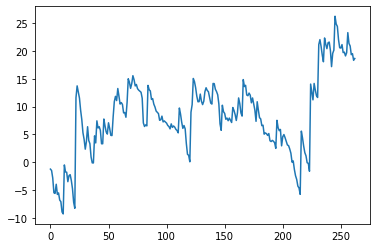

In [36]:
result.profit_abs_cum.plot()